# Modeling DALYs in Excel

# Introduction

The objective of this notebook is to walk readers through the process of modeling Disability-Adjusted Life Years (DALYs) in Microsoft Excel. We detail both (beginner, intermediate) approaches outlined in the tutorial manuscript.

The model and results can all be found in the accompanying Excel document [`sick-sicker-DALY.xlsm`](https://graveja0.github.io/dalys/_excel/sick-sicker-DALY.xlsm).

> **Note**
>
> Outcomes and results in the Excel document are slightly different than in the tutorial manuscript. A primary reason why is that the R code used for the main results interpolates (by age) the reference life table values for YLL calculations, while the Excel-based results rely on the `LOOKUP()` function, which does not interpolate.
>
> For example, the Global Burden of Deases Reference Life Table lists remaining life expectancy of 88.0 years for a 1 year old and 84.0 for a 5 year old. Thus, our R code would assign 3 year olds a remaining life expectancy value between 84.0 and 88.0, while Excel assigns a value of 88.0 (the value at 1 years old, which is the next-closest value that does not exceed 3 years of age).
>
> A second reason why results may differ slightly is that Excel does not have the capability to perform matrix exponentiation to embed the transition rate matrix into the defined discrete time step. Consequently, as discussed below we rely on a power series expansion of the rate matrix to embed the transition probability matrix. In practice, this results in transition probabilities that are very close to, but do not exactly match, what we obtain via matrix exponentiation in R using the `expm()` command.

# Step 1: Define Parameters

The worksheet **Parameters** is used to specify parameter names, values and descriptions. Note that the worksheet is divided into two (color-coded) sections: (1) parameters that are scalar inputs are shown in blue; while (2) those that are calculated as functions of other parameters are shown in red.

<figure>
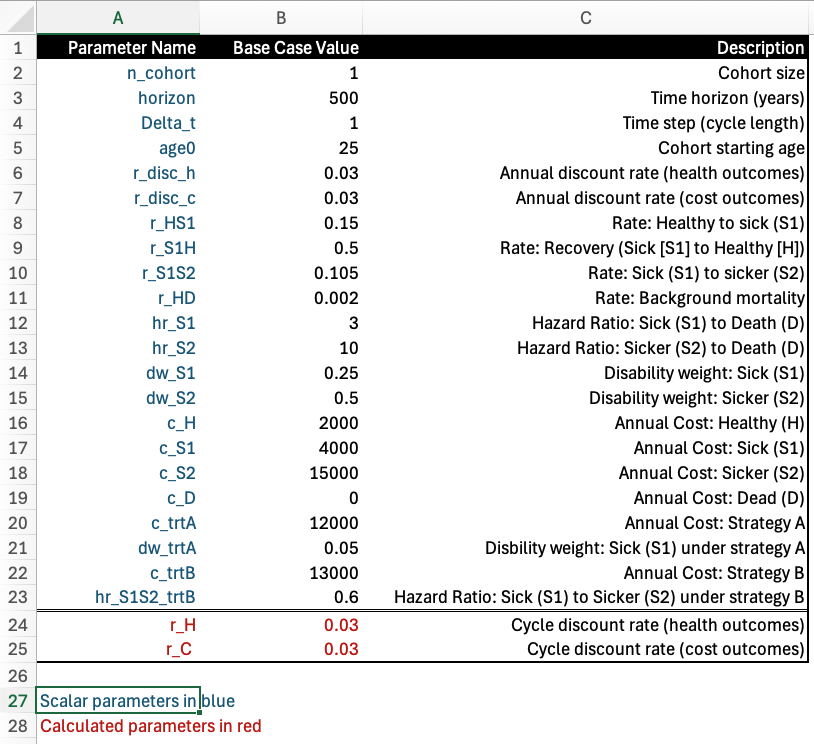
<figcaption>Parameters Tab</figcaption>
</figure>

## Naming Variables

Throughout the Excel document we rely on parameter and matrix names rather than cell definitions (e.g., “r_HD” is used in lieu of “Parameters\$B11”). To name variables, one can simply type in the preferred name into the upper left box (shown below for the parameter “n_cohort”).

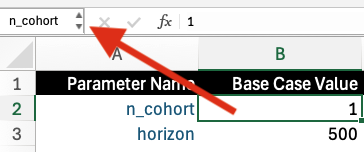{ fig-align="center"}

A similar approach will be used later to name matrices—but instead of selecting a single cell to name, we will select a region of cells to assign a single name to .

An alternative (more efficient) approach may be to batch name parameters all at once. To do this, select the region with parameters and values to be named, and then click “Create from Selection” in the ***Formulas*** tab. Make sure that the parameter names are to the left of the value for that parameter. Select “Left column” in the resulting popup box, and Excel will automatically assign parameter names to each value.

<figure>
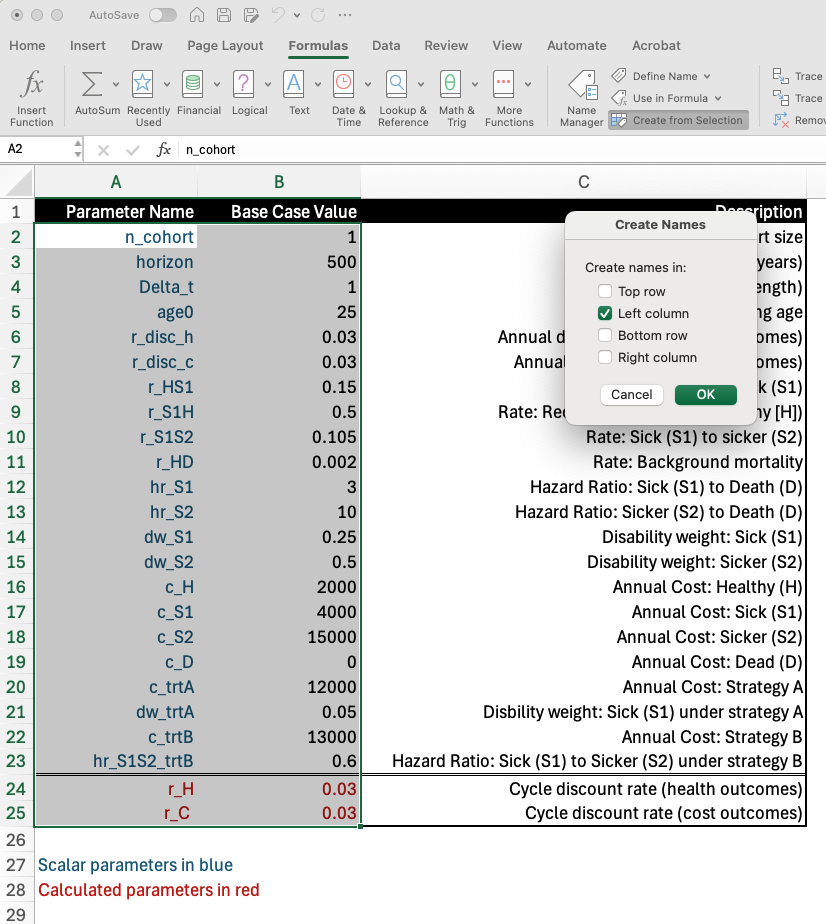
<figcaption>Naming parameters</figcaption>
</figure>

Names can be managed (e.g., edited, deleted, etc.) by clicking on the “Name Manager” in the *Formulas* tab:

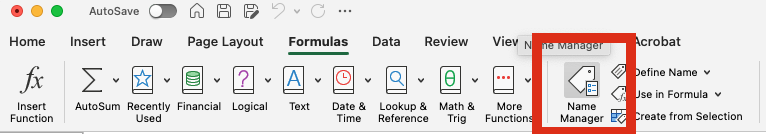

# Step 2: Construct Transition Matrices

The Excel document also contains two worksheets for constructing transition probability matrices—one for each approach.

## Beginner Approach

Transition probability matrices for Approach 1 (Beginner) are constructed in the Worksheet **Transition Matrices (App. 1).** Transition rates are inserted into a separate rate matrix for each strategy under the section titled “Transition Rate Matrices”:

<figure>
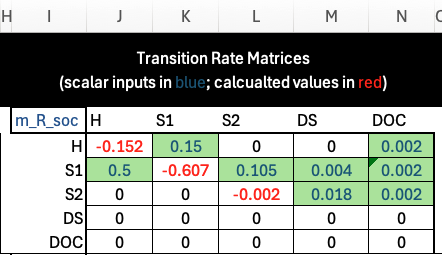
<figcaption>Transition rates</figcaption>
</figure>

Again, direct inputs are shown in Blue text while calculated values are shown in Red. In the table above, the rates are inserted using their parameter names, while the diagonal elements are calculated as the negative sum of the off-diagonal elements in the same row.

Above and to the left of each matrix you will also find a matrix name. To define matrices, we select the cell values of the matrix and then input the name into the cell directly to the left of the formula bar:

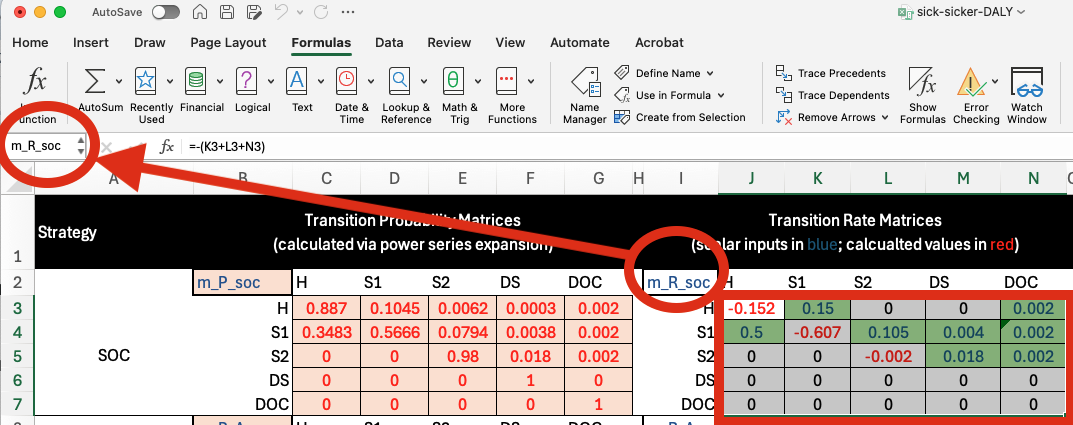

To the right of the transition rate matrix is a series of matrices that are used in the power series expansion that helps create the transition probability matrix (shown in red in the image above). The formula used for the power series expansion is

$$
e^{\mathbf{R}} = \sum_{k=0}^4 \frac{\mathbf{R}^k}{k!}
$$

Note that we only go up to $k=1,\dots, 4$ in the Excel document. Higher-order (e.g., $k = 1, \dots, 10$) approaches do not materially change the transition probabilities—though practitioners may find additional expansions are necessary for their applications.

The far-most left panel shows the final transition probability matrices calculated via the power series expansion. Again, one can see the defined matrix names (one for each strategy) just above and to the left of each matrix.

## Approach 2 (Intermediate)

Our intermediate approach relies on non-Markovian tracking states added to the “edges” of each matrix. The approach to embedding the transition probability matrix is essentially the same, with a few minor wrinkles which we discuss below.

The worksheet **Transition Matrices (App. 2)** details the transition matrices and calculations for Approach 2. As above, transition rates are entered directly (as parameter names) in the section titled “Transition Rate Matrices.

A key difference, however, is that the transition rate matrix is split into two parts: a Markovian submatrix and the Non-Markovian tracking states (which are highlighted in light blue):

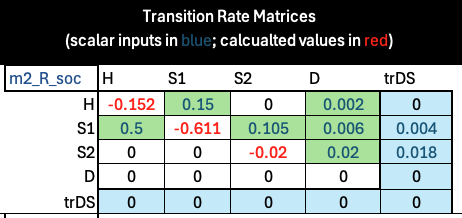{ fig-align="center"}

It is critically important that the diagonal elements are set to sum to zero *only for the cells in the Markovian submatrix* (i.e., these values do not include the cells highlighted in blue). In our formulation, all transitions to death are recorded in the “D” column, while only transitions to death due to disease-related causes are captured in the “trDS” tracking state column. This is a slight difference from Approach 1, which treats disease-related and other-cause-related death transitions as separate (mutually exclusive) health states.

As under Approach 1, the transition probability matrix is calculated via a power series expansion. However, there is one manual change that must be made to the matrix. After embedding, the tracking state “trDS” will be treated as an absorbing state (i.e., the probability of transition from trDS to trDS is 1.0). We must manually change this value to 0 to make “trDs” a transition tracking state:

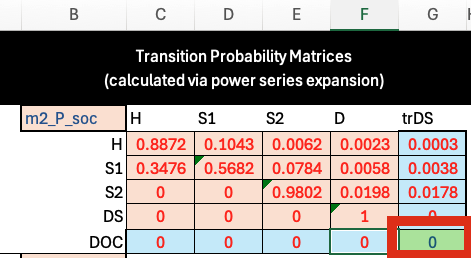{ fig-align="center"}

# Step 3: Outcomes

The Excel document contains a series of worksheets that work through outcome calculations under each strategy and methodological approach. For a given approach (beginner, intermediate), the worksheets for each strategy are essentially identical—the only differences are in the transition probability matrices and payoff vectors, which vary by strategy.

We will walk readers through a single strategy (“Standard of Care,” or “SOC”) as an example.

## Input Objects

The leftmost side of the worksheet has a variety of input objects; these are merely summaries that refer to parameter and matrix names defined above. This area also includes the reference life table from the GBD to facilitate calculation of YLL outcomes.

Payoffs are defined using parameters and the formulas as outlined in the main manuscript. A few are highlighted in the image below:

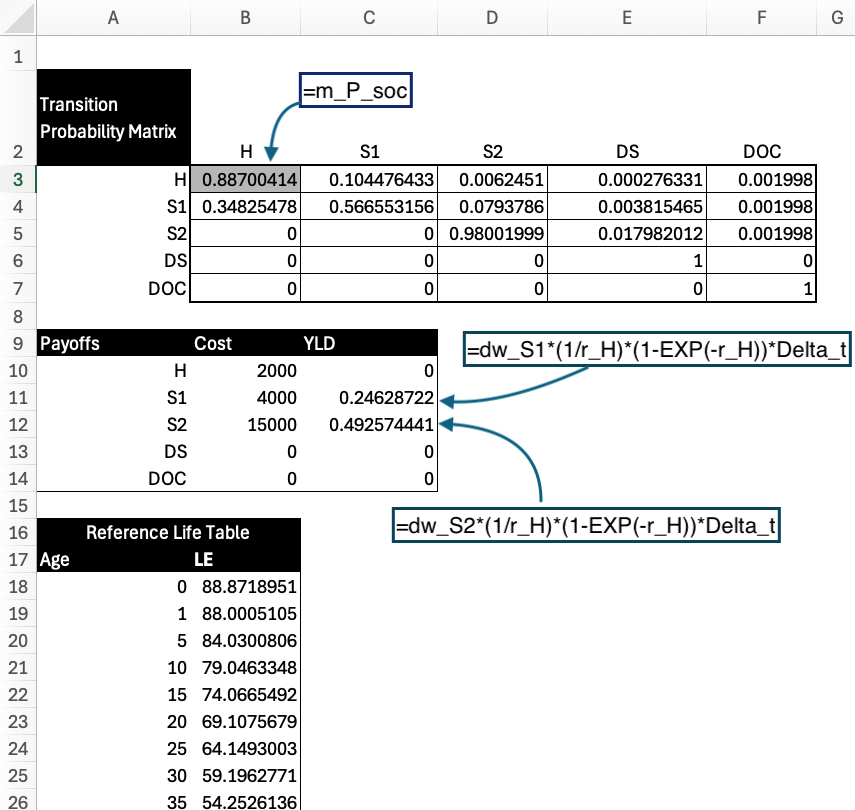{ fig-align="center" width="600"}

## Markov Trace

The next section over calculates the Markov trace for the modeled time horizon (500 years in this case). In cycle zero, we start with a healthy cohort (with size defined by the `n_cohort` parameter). The next row (cycle 1) is then calculated via matrix multiplication of the current state occupancy (i.e., the row for cycle=0) and the transition probability matrix):

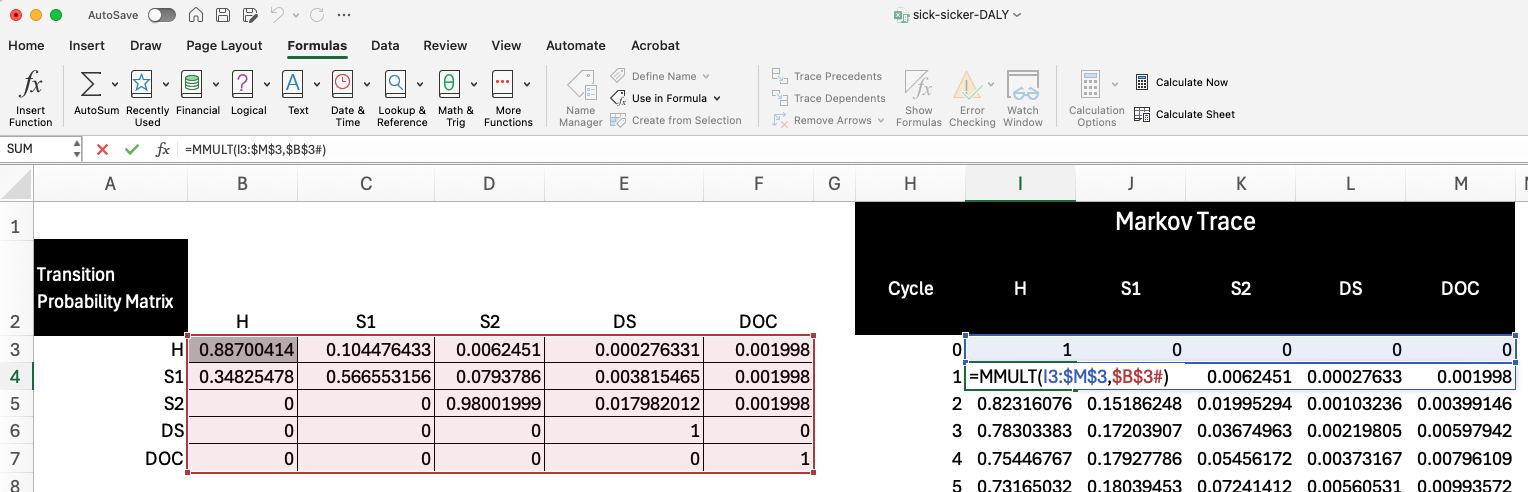{ fig-align="center"}

Each subsequent row is calculated using a similar process.

## Cycle Adjustments

The next panel contains columns for cycle adjustments based on discounting and a half-cycle correction. We combine these together to construct a cycle adjustment factor (\$c_t\$ in the manuscript) that will be used later.

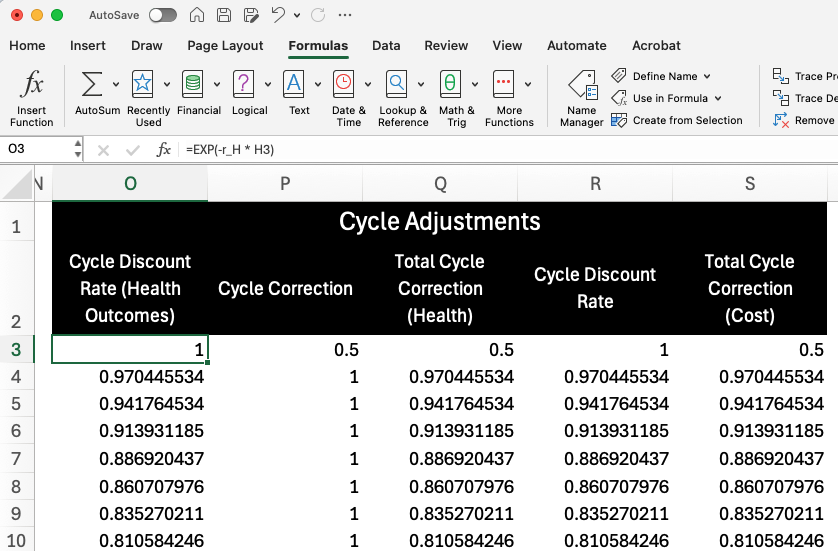{ fig-align="center" width="600"}

## Years of Life Lost to Premature Mortality (YLLs)

Columns U through Y provide the necessary numbers for YLL outcomes. We start by determining the age of the cohort in the model ($a_t$; Column U):

$$
a_t = a_0 +t \cdot \Delta_t 
$$  
where $a_0$ is the age of the cohort at $t=0$.

Column V then plugs this calculated age into a `LOOKUP()` function to obtain the value for remaining life expectancy from the reference life table ($Ex(a_t)$). As noted at the beginning of this document, `LOOKUP()` finds the value associated with closest age. The formulas then discount this value to the present value at the cycle using the following formula:

$$
Ex_{t} = \frac{1}{r}\big (1 - e^{-rEx(a_{t})} \big )
$$

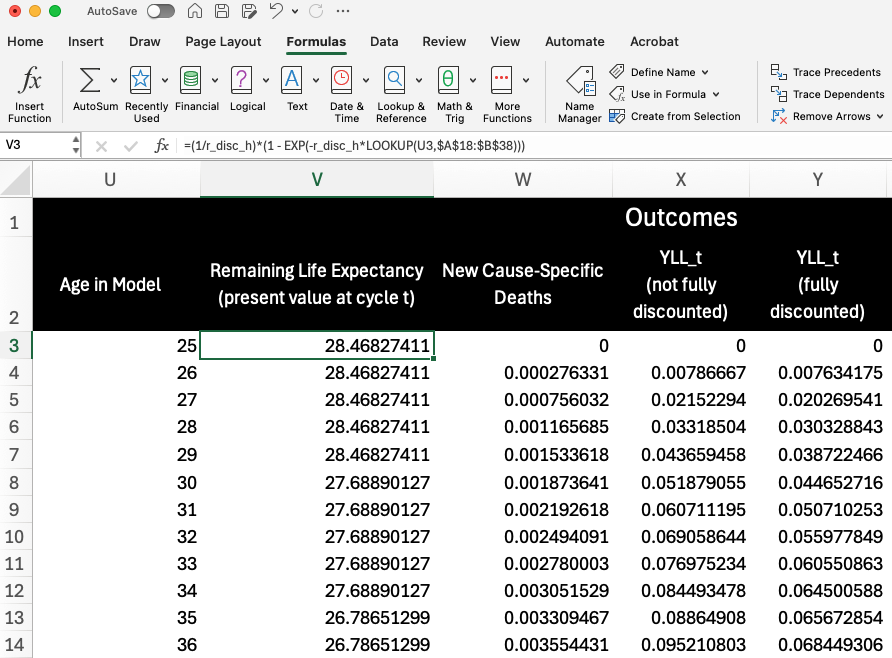{ fig-align="center" width="600"}

Next, Column W calculates the number of cause-specific deaths in the cycle based on the “DS” column in the Markov Trace:

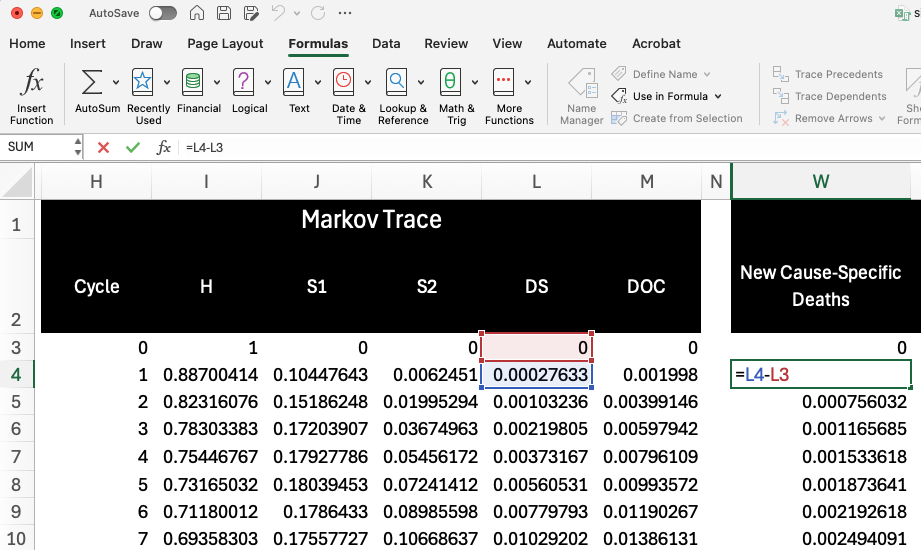{ fig-align="center" width="600"}

In Column L, we calculate the initial cycle-specific values for YLLs (`YLL_t`) by multiplying remaining life expectancy by the number of cause-specific deaths in the cycle.

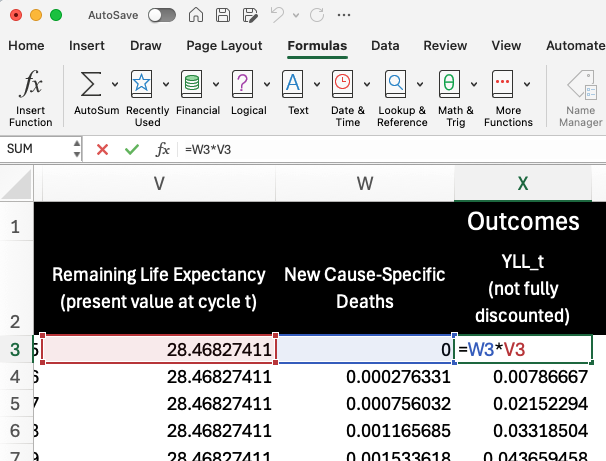{ fig-align="center" width="400"}

Column Y then calculates the final cycle-specific YLL values by multiplying by the cycle adjustment factor for health outcomes (Column Q). Again, this cycle-adjustment reflects both discounting and the half-cycle correction:

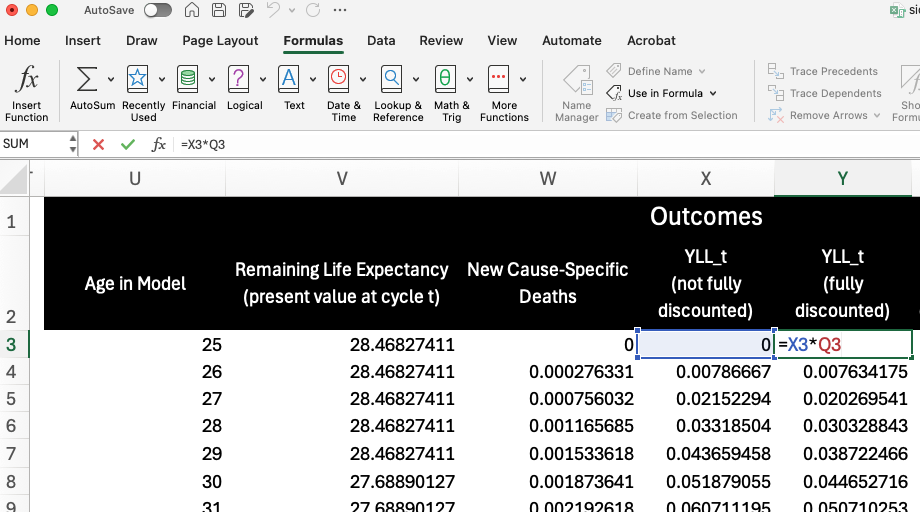{ fig-align="center" width="400"}

We then sum up the cycle specific YLL values to obtain expected YLLs over the model time horizon. This value is stored in the “Outcomes” table on the left-hand side of the worksheet. We also assign this value a name (“YLL_SOC”) using the parameter naming methods outlined above; this is useful later for creating summary tables.

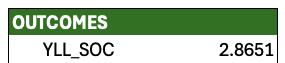{ fig-align="center" width="150"}

## Years of Life Lost to Disability and Costs

YLDs and costs are more straightforward to calculate as they require only matrix multiplication of the markov trace by the respective payoff vectors. We first calculate undiscounted and unadjusted cycle-specific values using matrix multiplication of the trace and the payoff vector. We then apply the health- and cost-specific cycle adjustment values (Columns Q and S) to obtain the final adjusted cycle-specific values for YLDs and Costs, and then sum up each column for the outcomes table.

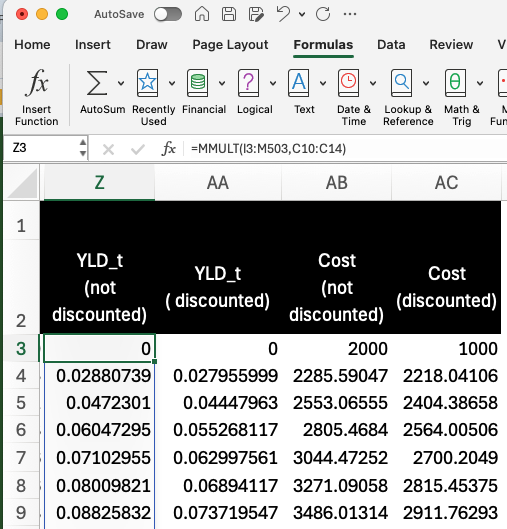{ fig-align="center" width="350"}

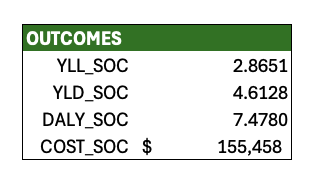{ fig-align="center" width="250"}

Finally, expected DALYs are calculated as the sum of YLL and YLD outcomes.

## Outcomes Under Approach 2

Expected outcomes are calculated for Approach 2 using a nearly identical process as above. The only difference is that the Markov trace itself already contains a count of new disease-related deaths in each cycle (in the “trDS” column); it does not need to be separately calculated, as we did in Column W above.

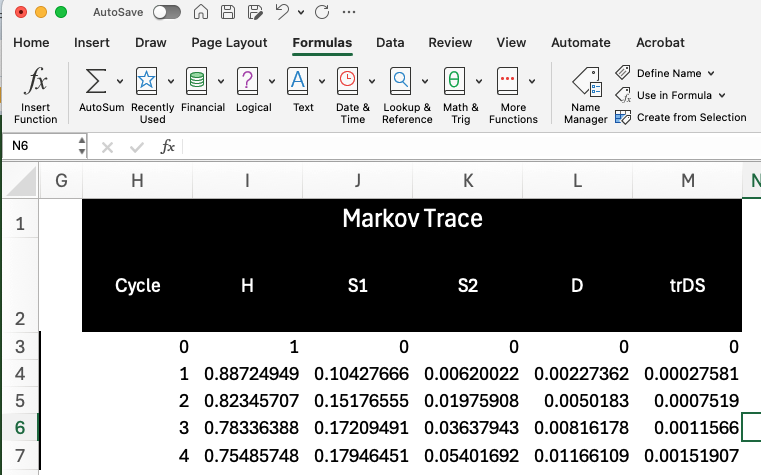{ fig-align="center" width="400"}

# Summary and Cost-Effectiveness Analysis

Finally, the worksheet **Summary and CEA** draws on the named expected outcome objects to summarize YLLs, YLDs, and DALYs under each approach and strategy. These values, along with the expected cost outcome, are then used to construct the CEA table.

Our results here closely match those in the tutorial manuscript, though are not identical due to the reasons outlined at the beginning of this document.

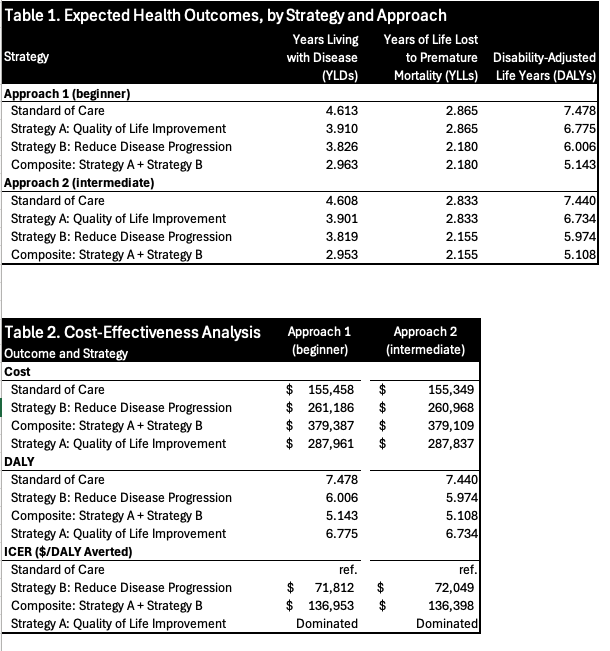